# Import

In [3]:
#pip install git+https://github.com/elben10/pydst

# general
import pydst
import pandas as pd
import numpy as np
from func import time_variable_plot, global_id, quarter_to_month, to_quarter
import re
from pyscbwrapper import SCB
import requests

# descriptive
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.dates as dates
from matplotlib.ticker import FuncFormatter

/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


# Statistics Denmark

## AUS08: unemployed persons (seasonally adjusted) by region and seasonal adjustment and actual figures (2007M01-2019M05)      

### Seasonally adjusted unemployment rate

In [24]:
## choose language 
Dst = pydst.Dst(lang='en')

# Request table with relevant parameters
# https://www.dst.dk/da/Statistik/statistikbanken/api
Dst.get_data(table_id = 'AUS08')

# Seasonally adjusted figures in percent of the labour force
# Create dataframe
df_DK_AUS08_adj = Dst.get_data(table_id = 'AUS08', variables={'OMRÅDE':['081', '082', '083', '084', '085'], 'TID':['*'], 'SAESONFAK': ['9']}) 

df_DK_AUS08_adj = df_DK_AUS08_adj.drop(['SAESONFAK'], axis=1)

#### Data cleaning

In [25]:
# change names 
df_DK_AUS08_adj = df_DK_AUS08_adj.rename(index=str, columns={"OMRÅDE": "region", "TID": "date", "INDHOLD": "target_season"})

In [26]:
# correst region names 
area = global_id()

df_DK_AUS08_adj = df_DK_AUS08_adj.merge(area[['ID', 'target']], right_on = 'target', left_on = 'region')
df_DK_AUS08_adj = df_DK_AUS08_adj.drop(['target', 'region'], axis = 1)


In [27]:
# Change format for the date variable 
df_DK_AUS08_adj['date'] = pd.to_datetime(df_DK_AUS08_adj['date'], format='%YM%m')

In [28]:
df_DK_AUS08_adj.head()

,date,target_season,ID
0,2009-09-01,6.5,North Denmark
1,2009-10-01,6.7,North Denmark
2,2008-09-01,3.0,North Denmark
3,2009-06-01,6.1,North Denmark
4,2009-02-01,4.5,North Denmark


In [29]:
# save the data 
#df_DK_AUS08_adj.to_csv(r'data/target/df_DK_AUS08_adj.csv', index = False)

### Actual unemployment rate

In [30]:
# Create dataframe
df_DK_AUS08_actual = Dst.get_data(table_id = 'AUS08', variables={'OMRÅDE':['081', '082', '083', '084', '085'], 'TID':['*'], 'SAESONFAK': ['22']}) 

df_DK_AUS08_actual = df_DK_AUS08_actual.drop(['SAESONFAK'], axis=1)

#### Data cleaning

In [31]:
# change names 
df_DK_AUS08_actual = df_DK_AUS08_actual.rename(index=str, columns={"OMRÅDE": "region", "TID": "date", "INDHOLD": "target_actual"})

In [32]:
# correst region names 

df_DK_AUS08_actual = df_DK_AUS08_actual.merge(area[['ID', 'target']], right_on = 'target', left_on = 'region')
df_DK_AUS08_actual = df_DK_AUS08_actual.drop(['target', 'region'], axis = 1)


In [33]:
# Change format for the date variable 
df_DK_AUS08_actual['date'] = pd.to_datetime(df_DK_AUS08_actual['date'], format='%YM%m')

In [34]:
df_DK_AUS08_actual.head()

,date,target_actual,ID
0,2009-09-01,5.7,North Denmark
1,2009-10-01,6.1,North Denmark
2,2008-09-01,2.7,North Denmark
3,2009-06-01,5.6,North Denmark
4,2009-02-01,5.4,North Denmark


In [35]:
# save the data 
#df_AUS08_regions_actual.to_csv(r'data/df_AUS08_regions_actual.csv', index = False)

### Preprocessing

#### Merge the two target variables 

In [36]:
df_DK_AUS08 = df_DK_AUS08_actual.merge(df_DK_AUS08_adj, on = ['date', 'ID'])

#### Create lagged variable

In [37]:
# Create lagged variable
df_DK_AUS08 = df_DK_AUS08.sort_values(['ID', 'date'], ascending=False)
df_DK_AUS08['target_actual_lag'] = df_DK_AUS08.groupby(['ID'])['target_actual'].shift(-1)
df_DK_AUS08['target_season_lag'] = df_DK_AUS08.groupby(['ID'])['target_season'].shift(-1)

In [38]:
df_DK_AUS08.head()

,date,target_actual,ID,target_season,target_actual_lag,target_season_lag
754,2019-09-01,3.3,Zealand,3.5,3.3,3.5
750,2019-08-01,3.3,Zealand,3.5,3.2,3.5
725,2019-07-01,3.2,Zealand,3.5,3.4,3.6
722,2019-06-01,3.4,Zealand,3.6,3.4,3.5
764,2019-05-01,3.4,Zealand,3.5,3.5,3.5


In [39]:
df_DK_AUS08 = df_DK_AUS08.drop(['target_season','target_actual_lag', 'target_season_lag'], axis = 1)

In [41]:
df_DK_AUS08.to_csv(r'DK/data/df_target_DK.csv', index = False)

## Descriptive statistics

### Seasonally adjusted unemployment rate

In [40]:
# read in file
df_DK_AUS08 = pd.read_csv("data/target/df_DK_AUS08.csv", parse_dates = ['date']) 

In [41]:
df_DK_AUS08.set_index('date', inplace = True)

/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


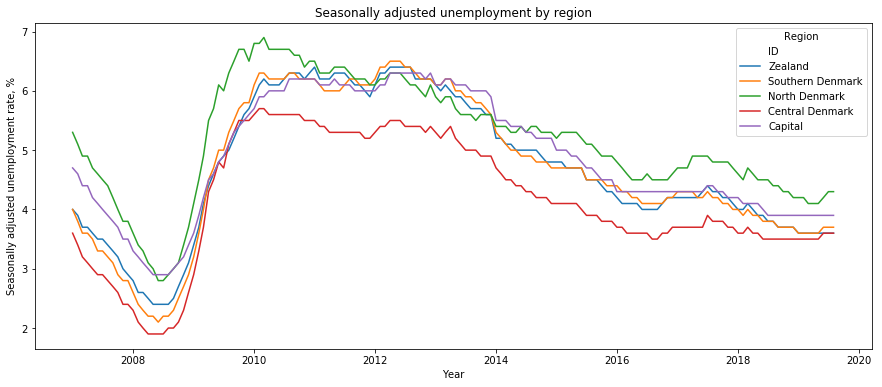

In [42]:
time_variable_plot(data= df_DK_AUS08, x = df_DK_AUS08.index, y="target_season", hue="ID", x_label = 'Year', y_label = 'Seasonally adjusted unemployment rate, %', title = 'Seasonally adjusted unemployment by region', legend_title = 'Region')

### Actual unemployment rate

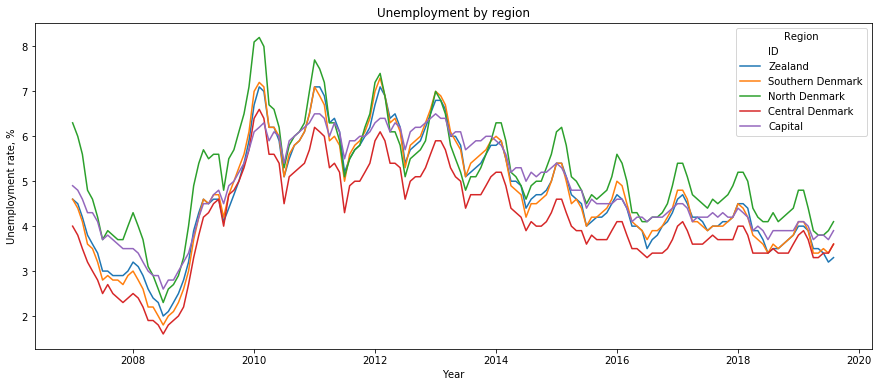

In [43]:
time_variable_plot(data= df_DK_AUS08, x = df_DK_AUS08.index, y="target_actual", hue="ID", x_label = 'Year', y_label = 'Unemployment rate, %', title = 'Unemployment by region', legend_title = 'Region')

## AKU120K: LABOUR FORCE STATUS BY EMPLOYMENT STATUS AND REGION (2007Q1-2019Q1)       

#### Method 1: Retrive the actual numbers

In [4]:
## choose language 
Dst = pydst.Dst(lang='en')

# Request table with relevant parameters
# https://www.dst.dk/da/Statistik/statistikbanken/api
Dst.get_data(table_id = 'AKU120')

# Seasonally adjusted figures in percent of the labour force
# Create dataframe
df_DK_AKU102 = Dst.get_data(table_id = 'AKU120K', variables={'BESKSTATUS': ['AKUL'], 'OMRÅDE': ['084', '085', '083', '082', '081'] , 'TID':['*']}) 
df_DK_AKU102_1 = Dst.get_data(table_id = 'AKU120K', variables={'BESKSTATUS': ['BESTOT'], 'OMRÅDE': ['084', '085', '083', '082', '081'] , 'TID':['*']}) 

In [5]:
# Change variable names 
df_DK_AKU102 = df_DK_AKU102.drop(['BESKSTATUS'], axis  =1)
df_DK_AKU102 = df_DK_AKU102.rename(index=str, columns={"OMRÅDE": "region", "TID": "date", "INDHOLD": "unemployed"})
df_DK_AKU102_1 = df_DK_AKU102_1.drop(['BESKSTATUS'], axis  =1)
df_DK_AKU102_1 = df_DK_AKU102_1.rename(index=str, columns={"OMRÅDE": "region", "TID": "date", "INDHOLD": "employed"})

In [6]:
# merge the two data frame 
df_DK_AKU102 = df_DK_AKU102.merge(df_DK_AKU102_1, on = ['region', 'date'])

In [7]:
df_DK_AKU102['target_actual'] = round(df_DK_AKU102['unemployed']/(df_DK_AKU102['unemployed'] + df_DK_AKU102['employed'])*100, ndigits = 2)

In [8]:
# Update the regions to ID in correct format 

area = global_id()

df_DK_AKU102=df_DK_AKU102.merge(area[['ID', 'target']], right_on = 'target', left_on = 'region')
df_DK_AKU102['labour_force'] = df_DK_AKU102['unemployed'] + df_DK_AKU102['employed'] 
df_DK_AKU102= df_DK_AKU102.drop(['target', 'region', 'employed', 'unemployed'], axis = 1)

In [9]:
# Convert to correct quarter format
df_DK_AKU102['date'] = pd.to_datetime(df_DK_AKU102['date'], format = '%YQ%m') 
df_DK_AKU102['date'] = [to_quarter(x) for x in df_DK_AKU102['date']]
# save the labour force 
df_DK_AKU102['labour_force'] = df_DK_AKU102['labour_force']*1000

In [10]:
df_DK_AKU102.head(10)

,date,target_actual,ID,labour_force
0,2019-07-01,5.48,North Denmark,292000
1,2013-07-01,7.45,North Denmark,282000
2,2013-10-01,5.84,North Denmark,274000
3,2014-01-01,7.55,North Denmark,278000
4,2014-04-01,6.64,North Denmark,286000
5,2014-07-01,7.39,North Denmark,284000
6,2014-10-01,6.76,North Denmark,281000
7,2015-01-01,7.12,North Denmark,281000
8,2015-04-01,6.60,North Denmark,288000
9,2015-07-01,6.25,North Denmark,288000


In [11]:
df_DK_AKU102.shape

(235, 4)

In [18]:
# to csv 
df_DK_AKU102[['date', 'target_actual', 'ID']].to_csv(r'data/target/df_DK_target.csv', index = False)
df_DK_AKU102[['date', 'labour_force', 'ID']].to_csv(r'data/job_posts/df_DK_labour_force.csv', index = False)

In [17]:
df_DK_AKU102.date.value_counts().sort_index()

2008-01-01    5
2008-04-01    5
2008-07-01    5
2008-10-01    5
2009-01-01    5
2009-04-01    5
2009-07-01    5
2009-10-01    5
2010-01-01    5
2010-04-01    5
2010-07-01    5
2010-10-01    5
2011-01-01    5
2011-04-01    5
2011-07-01    5
2011-10-01    5
2012-01-01    5
2012-04-01    5
2012-07-01    5
2012-10-01    5
2013-01-01    5
2013-04-01    5
2013-07-01    5
2013-10-01    5
2014-01-01    5
2014-04-01    5
2014-07-01    5
2014-10-01    5
2015-01-01    5
2015-04-01    5
2015-07-01    5
2015-10-01    5
2016-01-01    5
2016-04-01    5
2016-07-01    5
2016-10-01    5
2017-01-01    5
2017-04-01    5
2017-07-01    5
2017-10-01    5
2018-01-01    5
2018-04-01    5
2018-07-01    5
2018-10-01    5
2019-01-01    5
2019-04-01    5
2019-07-01    5
Name: date, dtype: int64

#### Method 2: Retrive the pct. 

In [52]:
## choose language 
Dst = pydst.Dst(lang='en')

# Request table with relevant parameters
# https://www.dst.dk/da/Statistik/statistikbanken/api
Dst.get_data(table_id = 'AKU122')

# Seasonally adjusted figures in percent of the labour force
# Create dataframe
df_DK_AKU122 = Dst.get_data(table_id = 'AKU122', variables={'BESKSTATUS': ['LPCT'], 'OMRÅDE': ['084', '085', '083', '082', '081'] , 'TID':['*']}) 


In [53]:
# Change variable names 
df_DK_AKU122 = df_DK_AKU122.rename(index=str, columns={"OMRÅDE": "region", "TID": "date", "INDHOLD": "target_actual"})

In [54]:
# Update the regions to ID in correct format 

area = global_id()

df_DK_AKU122=df_DK_AKU122.merge(area[['ID', 'target']], right_on = 'target', left_on = 'region')
df_DK_AKU122= df_DK_AKU122.drop(['target', 'region', 'BESKSTATUS'], axis = 1)

In [55]:
# Convert to correct quarter format
df_DK_AKU122['date'] = pd.to_datetime(df_DK_AKU122['date'], format = '%YQ%m') 
df_DK_AKU122['date'] = [to_quarter(x) for x in df_DK_AKU122['date']]


In [56]:
df_DK_AKU122.head(10)

,date,target_actual,ID
0,2007-01-01,6.0,North Denmark
1,2007-04-01,4.2,North Denmark
2,2007-07-01,4.1,North Denmark
3,2007-10-01,3.2,North Denmark
4,2008-01-01,4.7,North Denmark
5,2008-04-01,3.5,North Denmark
6,2008-07-01,3.4,North Denmark
7,2008-10-01,3.6,North Denmark
8,2009-01-01,6.9,North Denmark
9,2009-04-01,6.8,North Denmark


In [57]:
df_DK_AKU122.shape

(245, 3)

#### Check difference in the two methods 

In [58]:
merge = df_DK_AKU122.merge(df_DK_AKU102,left_index=True, right_index=True)

In [59]:
merge.shape

(245, 7)

In [60]:
merge['target_actual_y'] = merge['target_actual_y'].round(decimals = 1)

In [61]:
merge['diff'] = merge['target_actual_x'] - merge['target_actual_y']

In [62]:
merge['diff'].describe()

count    245.000000
mean      -0.004082
std        0.077246
min       -0.200000
25%       -0.100000
50%        0.000000
75%        0.000000
max        0.200000
Name: diff, dtype: float64

In [63]:
#merge.head(10)

In [22]:
df_DK_AKU122.head()

NameError: name 'df_DK_AKU122' is not defined

In [65]:
# save AKU122
df_DK_AKU122.to_csv(r'data/target/df_DK_AKU122.csv', index = False)

In [39]:

df_DK_AKU102[['date', 'labour_force', 'ID']].to_csv(r'data/job_posts/df_DK_labour_force.csv', index = False)
df_DK_AKU102[['date', 'labour_force', 'ID']].to_csv(r'data/other/df_DK_labour_force.csv', index = False)

## Descriptive statistics

### Actual unemployment rate

In [67]:
# read in file
df_DK_AKU122 = pd.read_csv("data/target/df_DK_AKU122.csv", parse_dates = ['date']) 

In [68]:
df_DK_AKU122.set_index('date', inplace = True)

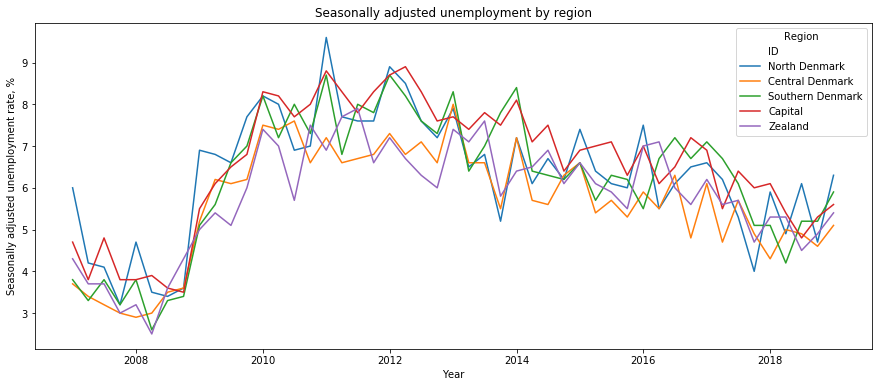

In [69]:
time_variable_plot(data= df_DK_AKU122, x = df_DK_AKU122.index, y="target_actual", hue="ID", x_label = 'Year', y_label = 'Seasonally adjusted unemployment rate, %', title = 'Seasonally adjusted unemployment by region', legend_title = 'Region')

# Statistics Sweden (SCB)

Note: This does only work for the swedish version of the API due to a incorrect variable definition for the english version for the given table 

## Target variable: Population aged 15-74 (LFS), percent by region, labour status, sex and quarter

In [3]:
# Define table specifications
scb = SCB('sv', 'AM', 'AM0401', 'AM0401N', 'NAKUBefolkningLK')
#print(scb.get_variables())

# Get list of variable in the table
regions = scb.get_variables()['region']
r = re.compile(r'.* län')
county = list(filter(r.match, regions))

#scb.get_variables()

#### Retrieve unemployed

In [4]:
# Specify the relevant variables
scb.set_query(region=county,
              tabellinnehåll = ['1000-tal'],
              kön=["totalt"], 
              arbetskraftstillhörighet = ['arbetslösa'])

# Retrieve data
scb_data =scb.get_data()
scb_fetch = scb_data['data']

# Get county codes
codes = scb.get_query()['query'][0]['selection']['values']

# dict with counties
countydic = {}
for i in range(len(codes)):
    countydic[codes[i]] = county[i]


# Get the correct format of the data
countydata = {}
for code in countydic:
    countydata[countydic[code]] = {}
    for i in range(len(scb_fetch)):
        if scb_fetch[i]['key'][0] == code:
            countydata[countydic[code]][scb_fetch[i]['key'][3]] = \
            float(scb_fetch[i]['values'][0])

# To dataframe
df_SE_target = pd.DataFrame(countydata)
df_SE_target_1 = pd.DataFrame(df_SE_target.unstack().reset_index())

In [5]:
# Change names
df_SE_target_1.columns = ['region', 'date', 'unemployed']

#### Retrieve employed 

In [6]:
# Retrieve employed 
# Specify the relevant variables
scb.set_query(region=county,
              tabellinnehåll = ['1000-tal'],
              kön=["totalt"], 
              arbetskraftstillhörighet = ['sysselsatta'])

# Retrieve data
scb_data =scb.get_data()
scb_fetch = scb_data['data']

# Get county codes
codes = scb.get_query()['query'][0]['selection']['values']

# dict with counties
countydic = {}
for i in range(len(codes)):
    countydic[codes[i]] = county[i]


# Get the correct format of the data
countydata = {}
for code in countydic:
    countydata[countydic[code]] = {}
    for i in range(len(scb_fetch)):
        if scb_fetch[i]['key'][0] == code:
            countydata[countydic[code]][scb_fetch[i]['key'][3]] = \
            float(scb_fetch[i]['values'][0])

# To dataframe
df_SE_target = pd.DataFrame(countydata)
df_SE_target = pd.DataFrame(df_SE_target.unstack().reset_index())

In [7]:
# Change names
df_SE_target.columns = ['region', 'date', 'employed']

In [8]:
# Merge dataframes 

df_SE_target = df_SE_target.merge(df_SE_target_1, on = ['region', 'date'])

In [9]:
# New variable with labour force 
df_SE_target['labour_force'] = df_SE_target['employed'] + df_SE_target['unemployed']
df_SE_target['target_actual'] = round(df_SE_target['unemployed'] / df_SE_target['labour_force']*100, ndigits=2)

In [10]:
df_SE_target = df_SE_target.drop(['employed', 'unemployed'], axis = 1)

In [11]:
# Update the regions to ID in correct format 
area = global_id()

df_SE_target=df_SE_target.merge(area[['ID', 'target']], right_on = 'target', left_on = 'region')
df_SE_target=df_SE_target.drop(['target', 'region'], axis = 1)


In [12]:
df_SE_target = df_SE_target.sort_values(['ID', 'date'])

In [13]:
# Convert to correct quarter format
df_SE_target['date'] = pd.to_datetime(df_SE_target['date'], format = '%YK%m') 

In [14]:
df_SE_target['date'] = [to_quarter(x) for x in df_SE_target['date']]

In [15]:
df_SE_target = df_SE_target.sort_values(['ID', 'date'])

In [16]:
df_SE_target.head(30)

,date,labour_force,target_actual,ID
464,2005-04-01,76.4,8.77,Blekinge
465,2005-07-01,76.8,8.20,Blekinge
466,2005-10-01,72.3,8.44,Blekinge
467,2006-01-01,73.5,8.30,Blekinge
468,2006-04-01,74.8,8.02,Blekinge
469,2006-07-01,76.7,4.56,Blekinge
470,2006-10-01,76.0,5.66,Blekinge
471,2007-01-01,77.7,8.11,Blekinge
472,2007-04-01,79.1,8.60,Blekinge
473,2007-07-01,80.3,6.85,Blekinge


In [17]:
df_SE_target.date.min()

Timestamp('2005-04-01 00:00:00')

In [18]:
df_SE_target.date.max()

Timestamp('2019-07-01 00:00:00')

In [19]:
# save 
df_SE_target.to_csv(r'data/target/df_SE_target.csv', index = False)


In [20]:
# to csv 
df_SE_target[['date', 'target_actual', 'ID']].to_csv(r'data/target/df_SE_target.csv', index = False)

In [21]:
# save labour force 
df_SE_target['labour_force'] = df_SE_target['labour_force']*1000
df_SE_target[['date', 'labour_force', 'ID']].to_csv(r'data/job_posts/df_SE_labour_force.csv', index = False)

## Descriptive plots 

In [87]:
# read in file
df_SE_target = pd.read_csv('data/target/df_SE_target.csv', parse_dates = ['date']) 

In [88]:
df_SE_target.set_index('date', inplace = True)

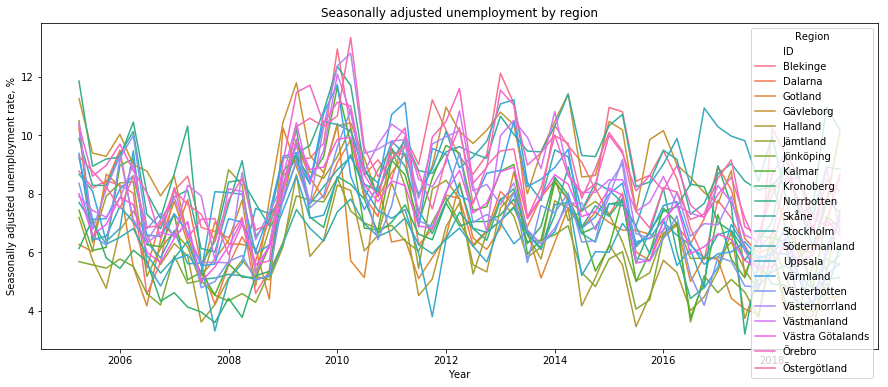

In [89]:
time_variable_plot(data= df_SE_target, x = df_SE_target.index, y="target_actual", hue="ID", x_label = 'Year', y_label = 'Seasonally adjusted unemployment rate, %', title = 'Seasonally adjusted unemployment by region', legend_title = 'Region')

## Norwegian Statistics Bank (SSB)

### Target variable: 05615: Persons in the labour force and employed persons, by region, sex, labour force status, contents and quarter

In [63]:
# url https://www.ssb.no/en/statbank/table/05615 
url = 'https://data.ssb.no/api/v0/en/table/05615'

In [64]:
# params
params = {
  "query": [
    {
      "code": "Region",
      "selection": {
        "filter": "item",
        "values": [
          "01",
          "02",
          "03",
          "04",
          "05",
          "06",
          "07",
          "08",
          "09",
          "10",
          "11",
          "12",
          "14",
          "15",
          "50",
          "16",
          "17",
          "18",
          "19",
          "20"
        ]
      }
    },
    {
      "code": "Kjonn",
      "selection": {
        "filter": "item",
        "values": [
          "0"
        ]
      }
    },
    {
      "code": "ContentsCode",
      "selection": {
        "filter": "item",
        "values": [
          "Sysselsatte"
        ]
      }
    }
  ],
  "response": {
    "format": "csv"
  }
}

In [65]:
# request data
r = requests.post(url, json = params)
r= r.text

In [66]:
# Save to CSV
text_file = open("data/target/df_NO_target.csv", "w", encoding="utf8")
text_file.write(r)
text_file.close()

### Preprocessing

In [67]:
# Open the csv file 
df_NO_target = pd.read_csv("data/target/df_NO_target.csv") 

In [68]:
df_NO_target = df_NO_target.drop(['sex'], axis = 1)
#df_NO_target.head()

In [69]:
#subset data for each group
temp = df_NO_target[df_NO_target['labour force status'] == 'Employed persons']
temp = temp.drop(['labour force status'], axis = 1)
temp = temp.set_index(['region'])

# pivot
temp  = pd.DataFrame(temp.unstack())

# Change variable names 
temp = temp.reset_index()
temp = temp.rename(index=str, columns={'level_0': 'date', 0:'employed'})
#temp.head()

In [70]:
temp2 = df_NO_target[df_NO_target['labour force status'] == 'Persons in the labour force']
temp2 = temp2.drop(['labour force status'], axis = 1)
temp2 = temp2.set_index(['region'])

# pivot
temp2  = pd.DataFrame(temp2.unstack())

# Change variable names 
temp2 = temp2.reset_index()
temp2 = temp2.rename(index=str, columns={'level_0': 'date', 0:'labour_force'})
#temp2.head()

In [71]:
# Merge the 2 dataframes
df_NO_target = temp2.merge(temp, on = ['date', 'region'])

# New target variable 
df_NO_target['target_actual'] = round((1-(df_NO_target['employed']/df_NO_target['labour_force']))*100, ndigits=2)
df_NO_target = df_NO_target.drop(['employed'], axis = 1)
df_NO_target.head()

,date,region,labour_force,target_actual
0,Persons (1 000) 1996K1,01 Østfold,117,5.98
1,Persons (1 000) 1996K1,02 Akershus,239,3.77
2,Persons (1 000) 1996K1,03 Oslo,233,5.15
3,Persons (1 000) 1996K1,04 Hedmark,69,5.80
4,Persons (1 000) 1996K1,05 Oppland,111,6.31


In [72]:
df_NO_target['date'] = [x.replace('Persons (1 000) ', '') for x in df_NO_target.date]


df_NO_target = df_NO_target[~df_NO_target.date.str.contains("Gml")]
#df_NO_target['date'] = [x.replace(' Gml', '') for x in df_NO_target.date]

In [73]:
# Correct date format
df_NO_target['date'] = pd.to_datetime(df_NO_target['date'], format = '%YK%m') 
df_NO_target['date'] = [to_quarter(x) for x in df_NO_target['date']]

In [74]:
# Update the regions to ID in correct format 
area = global_id()

df_NO_target=df_NO_target.merge(area[['ID', 'target']], right_on = 'target', left_on = 'region')
df_NO_target=df_NO_target.drop(['target', 'region'], axis = 1)

In [75]:
#df_NO_target.head(50)

In [76]:
df_NO_target.to_csv("data/other/df_NO_labour_force.csv", index = False) 

##### Collapse Nord-Trøndeslag and Sør-Trøndelag to Trøndelag

In [77]:
test = df_NO_target[df_NO_target['ID'].isin(['Nord-Trøndelag'])]
test = test.reset_index()
test['Nord_product'] = test['labour_force'] * test['target_actual']
test = test.drop(['index'], axis = 1)

test = test[['date', 'Nord_product','labour_force']]

test2 = df_NO_target[df_NO_target['ID'].isin(['Nord-Trøndelag'])]
test2 = test2.reset_index()
test2['Sør_product'] = test2['labour_force'] * test2['target_actual']
test2 = test2.drop(['index'], axis = 1)

test2 = test2[['date', 'Sør_product', 'labour_force']]
#test.pivot(index='ID', columns = 'date', values='product')

In [78]:
test = test.merge(test2, on = ['date'])
test['target_new'] = (test['Nord_product'] + test['Sør_product']) / (test['labour_force_x'] + test['labour_force_y'])

In [79]:
test = test[['date', 'target_new']]
test['date'] = pd.to_datetime(test['date'], format = '%Y%m%d') 
df_NO_target['date'] = pd.to_datetime(df_NO_target['date'], format = '%Y%m%d') 

In [80]:
test = df_NO_target[(df_NO_target['ID']=='Trøndelag') & (np.isnan(df_NO_target['target_actual']))].merge(test,on='date')
test = test[['date', 'ID', 'target_new']]

In [81]:
df_NO_target = df_NO_target.merge(test, on = ['date', 'ID'], how = 'left')

df_NO_target['target_actual'] = np.where(np.isnan(df_NO_target.target_actual), df_NO_target.target_new, df_NO_target.target_actual)

In [82]:
df_NO_target = df_NO_target.drop(['target_new'], axis = 1)

In [83]:
# Drop Sør-Trøndelag and Nord-Trøndelag
df_NO_target = df_NO_target[df_NO_target['ID'].isin(['Sør-Trøndelag', 'Nord-Trøndelag']) == False]

In [84]:
# to csv 
df_NO_target[['date', 'target_actual', 'ID']].to_csv(r'data/target/df_NO_target.csv', index = False)

In [85]:
# save labour force 
df_NO_target['labour_force'] = df_NO_target['labour_force']*1000
df_NO_target[['date', 'labour_force', 'ID']].to_csv(r'data/job_posts/df_NO_labour_force.csv', index = False)

In [86]:
df_NO_target.sort_values(['ID', 'date']).head()

,date,labour_force,target_actual,ID
94,1996-01-01,239000,3.77,Akershus
95,1996-04-01,232000,3.45,Akershus
96,1996-07-01,240000,4.58,Akershus
97,1996-10-01,234000,2.99,Akershus
98,1997-01-01,245000,2.86,Akershus


In [87]:
df_NO_target.head()

,date,labour_force,target_actual,ID
0,1996-01-01,117000,5.98,Østfold
1,1996-04-01,126000,4.76,Østfold
2,1996-07-01,124000,4.03,Østfold
3,1996-10-01,115000,4.35,Østfold
4,1997-01-01,120000,5.00,Østfold


In [88]:
df_NO_target[['date','ID', 'labour_force']].to_csv('data/job_posts/df_NO_labour_force.csv', index = False)

In [89]:
df_NO_target[['date','ID', 'labour_force']][df_NO_target.ID == 'Trøndelag']

,date,ID,labour_force
1316,1996-01-01,Trøndelag,0
1317,1996-04-01,Trøndelag,0
1318,1996-07-01,Trøndelag,0
1319,1996-10-01,Trøndelag,0
1320,1997-01-01,Trøndelag,0
...,...,...,...
1405,2018-04-01,Trøndelag,245000
1406,2018-07-01,Trøndelag,244000
1407,2018-10-01,Trøndelag,241000
1408,2019-01-01,Trøndelag,247000


In [90]:
# To csv file 
df_NO_target.to_csv("data/target/df_NO_target.csv", index = False)

## Descriptive plots 

In [114]:
# read in file
df_NO_target = pd.read_csv('data/target/df_NO_target.csv', parse_dates = ['date']) 

In [115]:
df_NO_target.set_index('date', inplace = True)

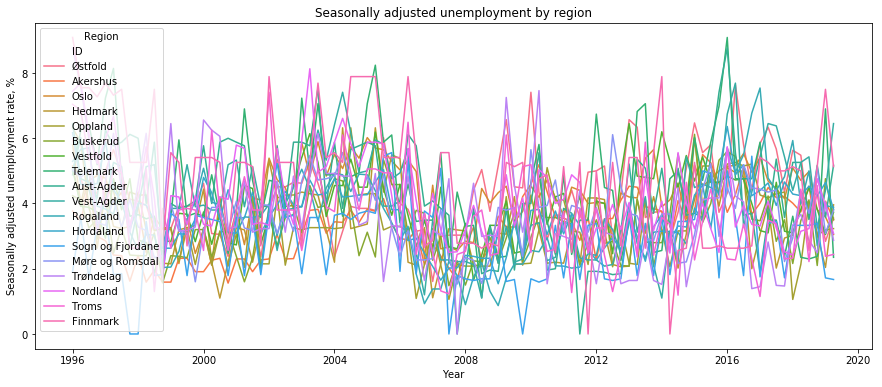

In [116]:
time_variable_plot(data= df_NO_target, x = df_NO_target.index, y="target_actual", hue="ID", x_label = 'Year', y_label = 'Seasonally adjusted unemployment rate, %', title = 'Seasonally adjusted unemployment by region', legend_title = 'Region')